In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch

from netam.framework import load_crepe

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

Load and restrict to human antibodies.

In [2]:
sd_df = pd.read_csv('../data/sabdab_summary_2024-01-26_abid_info_resnums.tsv.gz', sep='\t')
sd_df["vh_family"] = sd_df["vb"].str.extract(r'(IGHV\d+)')
sd_df = sd_df[sd_df["organism"] == "human_ig"].reset_index(drop=True)
sd_df["vh_family"].value_counts().head(12)

vh_family
IGHV3    2237
IGHV1    1502
IGHV4     604
IGHV5     163
IGHV2     104
IGHV7      51
IGHV6      31
Name: count, dtype: int64

# NOTE check what model we're using below

In [3]:
crepe_path = "../train/trained_models/dnsm_1m-v1tang-joint"
#crepe_path = "../train/trained_models/dnsm_1m-v1jaffeV34+v1tangV34-joint"
# crepe_path = "../train/trained_models/dnsm_sml-10x-joint"
#crepe_path = "../train/trained_models/dnsm_lrg-tang-joint"
model = load_crepe(crepe_path).model


In [4]:
# This cell is just make a CSV of the Chothia numbering for the V genes.
chothia_dict = {}
for gene in sd_df["vb"].unique():
    chothia_dict[gene] = sd_df[sd_df["vb"] == gene]["chothia_b"].iloc[0].split(",")
# make pd.DataFrame(chothia_dict), padding with -1s as needed
max_length = max(len(arr) for arr in chothia_dict.values())
chothia_dict_padded = {gene: arr + ([-1] * (max_length - len(arr))) for gene, arr in chothia_dict.items()}
chothia_df = pd.DataFrame(chothia_dict_padded)
# set one-indexed index
chothia_df.index = np.arange(1, max_length + 1)
# sort columns lexicographically
chothia_df = chothia_df.reindex(sorted(chothia_df.columns), axis=1)
chothia_df.to_csv("_ignore/chothia_df.csv")

In [5]:
# Extracting and sorting the unique Chothia numbering
all_sites = set()
for numbering in sd_df["chothia_b"]:
    all_sites.update(numbering.split(","))
sorted_sites = sorted(all_sites, key=lambda x: (int(x.rstrip("ABCDEFGHIJKLMNOPQRSTUVWXYZ")), x))

In [6]:
def build_aligned_df(sd_df, row_name):
    """
    Build a dataframe that has the tensor entries in `row_name` aligned with the Chothia numbering.
    """
    aligned_df = pd.DataFrame(columns=["pdbid", "abid", "vh_family"] + sorted_sites, dtype=float)

    # Populating the new DataFrame with dnsm values, using Chothia numbering directly
    for index, row in sd_df.iterrows():
        chothia_sites = row["chothia_b"].split(",")
        # if row[row_name] is a tensor, convert it to numpy array
        if isinstance(row[row_name], torch.Tensor):
            row_values = row[row_name].numpy()
        else:
            row_values = row[row_name]
        for site, value in zip(chothia_sites, row_values):
            aligned_df.at[index, site] = value

    # Ensure non-specified sites are NaN
    aligned_df = aligned_df.fillna(np.nan)

    # Copying the basic info from the original df
    aligned_df[["pdbid", "abid", "vh_family"]] = sd_df[["pdbid", "abid", "vh_family"]].values
    
    return aligned_df

### Selection factors

In [7]:
sd_df["dnsm"] = sd_df["chainseq_b"].apply(model.selection_factors_of_aa_str)

dnsm_df = build_aligned_df(sd_df, "dnsm")
dnsm_df


,pdbid,abid,vh_family,1,2,3,4,5,6,6A,...,102,103,104,105,106,107,108,109,110,111
0,1adq,1adqHL,IGHV3,0.633693,0.282328,0.429063,0.169452,0.424491,0.190310,NaN,...,0.929490,0.001464,0.188420,0.727864,0.053165,1.152233,0.955607,0.173765,0.567560,0.087140
1,1bvk,1bvkBA,IGHV4,0.105989,0.619257,0.398054,0.157716,0.464143,0.150441,NaN,...,0.737303,0.002041,0.269048,0.766073,0.107261,1.138846,0.897120,0.188160,0.453293,0.103814
2,1bvk,1bvkED,IGHV4,0.105989,0.619257,0.398054,0.157716,0.464143,0.150441,NaN,...,0.737303,0.002041,0.269048,0.766073,0.107261,1.138846,0.897120,0.188160,0.453293,0.103814
3,1dee,1deeFE,IGHV3,0.564634,0.302990,0.365799,0.234986,0.304297,0.203324,NaN,...,1.062713,0.001104,0.027949,0.637365,0.015860,0.472085,0.776468,0.275866,0.582591,0.064218
4,1dee,1deeDC,IGHV3,0.564634,0.302990,0.365799,0.234986,0.304297,0.203324,NaN,...,1.062713,0.001104,0.027949,0.637365,0.015860,0.472085,0.776468,0.275866,0.582591,0.064218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,7lxm,7lxmPO,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4688,7lxn,7lxnJN,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4689,7lxn,7lxnIM,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4690,7lxn,7lxnHL,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101


In [8]:
chainseq_df = pd.DataFrame(columns=["pdbid", "abid", "vh_family"] + sorted_sites)

# Copying basic info
chainseq_df[["pdbid", "abid", "vh_family"]] = sd_df[["pdbid", "abid", "vh_family"]].values

# Populating with amino acids from chainseq_b, placing dashes where sites aren't specified
for index, row in sd_df.iterrows():
    chothia_sites = row["chothia_b"].split(",")
    aa_sequence = row["chainseq_b"]
    # Initialize all sites with dashes
    for site in sorted_sites:
        chainseq_df.at[index, site] = '-'
    # Fill in amino acids for specified sites
    for site, aa in zip(chothia_sites, aa_sequence):
        chainseq_df.at[index, site] = aa

chainseq_df

pre_consensus_df = chainseq_df.drop(columns=["pdbid", "abid"])
consensus_df = pre_consensus_df.groupby("vh_family").agg(lambda x: x.value_counts().idxmax())

In [9]:
# Restrict to top VH families
family_count = 5
top_vh_families = dnsm_df["vh_family"].value_counts().nlargest(family_count).index
dnsm_plot_df = dnsm_df[dnsm_df["vh_family"].isin(top_vh_families)]

In [10]:
dnsm_plot_df

,pdbid,abid,vh_family,1,2,3,4,5,6,6A,...,102,103,104,105,106,107,108,109,110,111
0,1adq,1adqHL,IGHV3,0.633693,0.282328,0.429063,0.169452,0.424491,0.190310,NaN,...,0.929490,0.001464,0.188420,0.727864,0.053165,1.152233,0.955607,0.173765,0.567560,0.087140
1,1bvk,1bvkBA,IGHV4,0.105989,0.619257,0.398054,0.157716,0.464143,0.150441,NaN,...,0.737303,0.002041,0.269048,0.766073,0.107261,1.138846,0.897120,0.188160,0.453293,0.103814
2,1bvk,1bvkED,IGHV4,0.105989,0.619257,0.398054,0.157716,0.464143,0.150441,NaN,...,0.737303,0.002041,0.269048,0.766073,0.107261,1.138846,0.897120,0.188160,0.453293,0.103814
3,1dee,1deeFE,IGHV3,0.564634,0.302990,0.365799,0.234986,0.304297,0.203324,NaN,...,1.062713,0.001104,0.027949,0.637365,0.015860,0.472085,0.776468,0.275866,0.582591,0.064218
4,1dee,1deeDC,IGHV3,0.564634,0.302990,0.365799,0.234986,0.304297,0.203324,NaN,...,1.062713,0.001104,0.027949,0.637365,0.015860,0.472085,0.776468,0.275866,0.582591,0.064218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,7lxm,7lxmPO,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4688,7lxn,7lxnJN,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4689,7lxn,7lxnIM,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101
4690,7lxn,7lxnHL,IGHV4,0.099538,0.573870,0.745890,0.141570,0.539608,0.148339,NaN,...,0.273963,0.017090,0.121891,0.517592,0.102562,0.411861,0.270656,0.158158,0.491526,0.182101


In [11]:
melted_dnsm_df = dnsm_plot_df.melt(id_vars=["pdbid", "abid", "vh_family"], var_name="site", value_name="selection factor")

# Sorting melted DataFrame by vh_family alphanumerically for plotting
melted_dnsm_df["vh_family_sorted"] = pd.Categorical(melted_dnsm_df["vh_family"], categories=np.sort(melted_dnsm_df["vh_family"].unique()), ordered=True)

# make non_nan_df by dropping all rows in which selection factor is NaN
non_nan_df = melted_dnsm_df.dropna()
popular_sites = non_nan_df.groupby(["site", "vh_family"]).count().reset_index().groupby("site").count().query("vh_family >= 3").index
popular_sites_df = non_nan_df[non_nan_df["site"].isin(popular_sites)]
popular_sites_df

,pdbid,abid,vh_family,site,selection factor,vh_family_sorted
0,1adq,1adqHL,IGHV3,1,0.633693,IGHV3
1,1bvk,1bvkBA,IGHV4,1,0.105989,IGHV4
2,1bvk,1bvkED,IGHV4,1,0.105989,IGHV4
3,1dee,1deeFE,IGHV3,1,0.564634,IGHV3
4,1dee,1deeDC,IGHV3,1,0.564634,IGHV3
...,...,...,...,...,...,...
811355,7lxm,7lxmPO,IGHV4,111,0.182101,IGHV4
811356,7lxn,7lxnJN,IGHV4,111,0.182101,IGHV4
811357,7lxn,7lxnIM,IGHV4,111,0.182101,IGHV4
811358,7lxn,7lxnHL,IGHV4,111,0.182101,IGHV4


In [12]:
cmeanlonserved_sites_df = popular_sites_df.groupby(
    ['site'], observed=True
).agg(
    median_selection_factor=('selection factor', 'median'),
)

# Calculate median selection factor grouped by vh_family and site
median_df = popular_sites_df.groupby(['vh_family', 'site'], observed=True).agg(
    median_selection_factor=('selection factor', 'median'),
    count=('selection factor', 'count')
).reset_index()

median_df = median_df.query("count >= 100")

def second_smallest(values):
    sorted_values = sorted(values)
    return sorted_values[1] if len(sorted_values) > 1 else 1e5

second_smallest_df = median_df.groupby('site').agg(
    second_smallest_median_selection_factor=('median_selection_factor', second_smallest)
).reset_index()

# set the conserved_threshold to be the value of the 20th smallest second_smallest_median_selection_factor
conserved_threshold = second_smallest_df["second_smallest_median_selection_factor"].nsmallest(20).iloc[-1]
conserved_sites_df = second_smallest_df.query("second_smallest_median_selection_factor <= @conserved_threshold")

#conserved_sites_df = conserved_sites_df.query("median_selection_factor <= @conserved_threshold")
conserved_sites_df.sort_index(inplace=True)

# subset columns of consensus_df from conserved_sites_df.index
conserved_aa_df = consensus_df[conserved_sites_df["site"]]
conserved_aa_df = conserved_aa_df.loc[:, (conserved_aa_df != '-').any()]

# Take the most common amino acid at each site across V genes
conserved_aa_series = conserved_aa_df.mode().iloc[0]
conserved_aa_series

103    W
104    G
106    G
111    V
15     G
17     S
20     L
21     S
22     C
36     W
38     R
41     P
47     W
6      Q
7      S
8      G
86     D
9      P
90     Y
92     C
Name: 0, dtype: object

In [13]:
def plot_selection_factors(ax, df, conserved_aa_series, mode="all"):
    """
    Plots selection factors on the given axis.

    Parameters:
    - ax: matplotlib axis object
    - df: DataFrame containing the data to plot
    - conserved_aa_series: Series containing conserved amino acids
    - mode: str, one of "all", "first_half", or "second_half"
      - "all": plot all data
      - "first_half": plot the first half of the data
      - "second_half": plot the second half of the data
    """
    palette = plt.get_cmap('tab10').colors

    # Determine the range of sites to plot based on the mode
    unique_sites = df["site"].unique()
    site_offset = 0
    if mode == "first_half":
        half_index = len(unique_sites) // 2
        df = df[df["site"].isin(unique_sites[:half_index])]
        site_range = range(half_index)
    elif mode == "second_half":
        half_index = len(unique_sites) // 2
        df = df[df["site"].isin(unique_sites[half_index:])]
        site_range = range(half_index, len(unique_sites))
        site_offset = - half_index
    else:  # mode == "all"
        site_range = range(len(unique_sites))

    # Plot the pointplot
    sns.pointplot(data=df, x="site", y="selection factor", hue="vh_family_sorted", linestyle='none', 
                  alpha=0.5, dodge=0.5, palette=palette, markers='.', errorbar=('pi', 75), 
                  estimator=np.median, err_kws={'linewidth': 1}, ax=ax)
 
    # Add shaded vertical regions
    for i in site_range:
        offset_i = i + site_offset
        if i % 2 == 1:
            ax.axvspan(offset_i - 0.5, offset_i + 0.5, color='grey', alpha=0.1, lw=0)

    # Customize tick labels
    ax.tick_params(axis='x', which='both', labelsize=24, rotation=90)
    ax.tick_params(axis='y', which='both', labelsize=28)

    ax.set_xlim(-0.5, len(site_range) - 0.5)

    # Add horizontal dashed line at y=1
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)

    # Customize legend
    ax.legend(loc='upper left', fontsize=28, markerscale=4)

    # Set labels
    ax.set_xlabel('Chothia numbering', fontsize=36)
    if mode == "first_half":
        ax.set_xlabel('')
    ax.set_ylabel('Selection Factor', fontsize=36)

    # Remove the top and right spines
    sns.despine(ax=ax)

    # ax.text(1.2, -0.05, 'Conserved amino acids:', ha='center', va='center', fontsize=20, color='black')
    # set aa_text_color to be the 6th color in the palette
    aa_text_color = palette[5]
    for site, aa in conserved_aa_series.items():
        if mode == "all" or (mode == "first_half" and site in unique_sites[:half_index]) or (mode == "second_half" and site in unique_sites[half_index:]):
            ax.text(site, -0.05, aa, ha='center', va='center', fontsize=22, color="grey", fontweight=1000, font="monospace")
    
    ax.axhline(y=conserved_threshold, color='gray', linestyle=':', linewidth=1)
    
    plt.tight_layout()

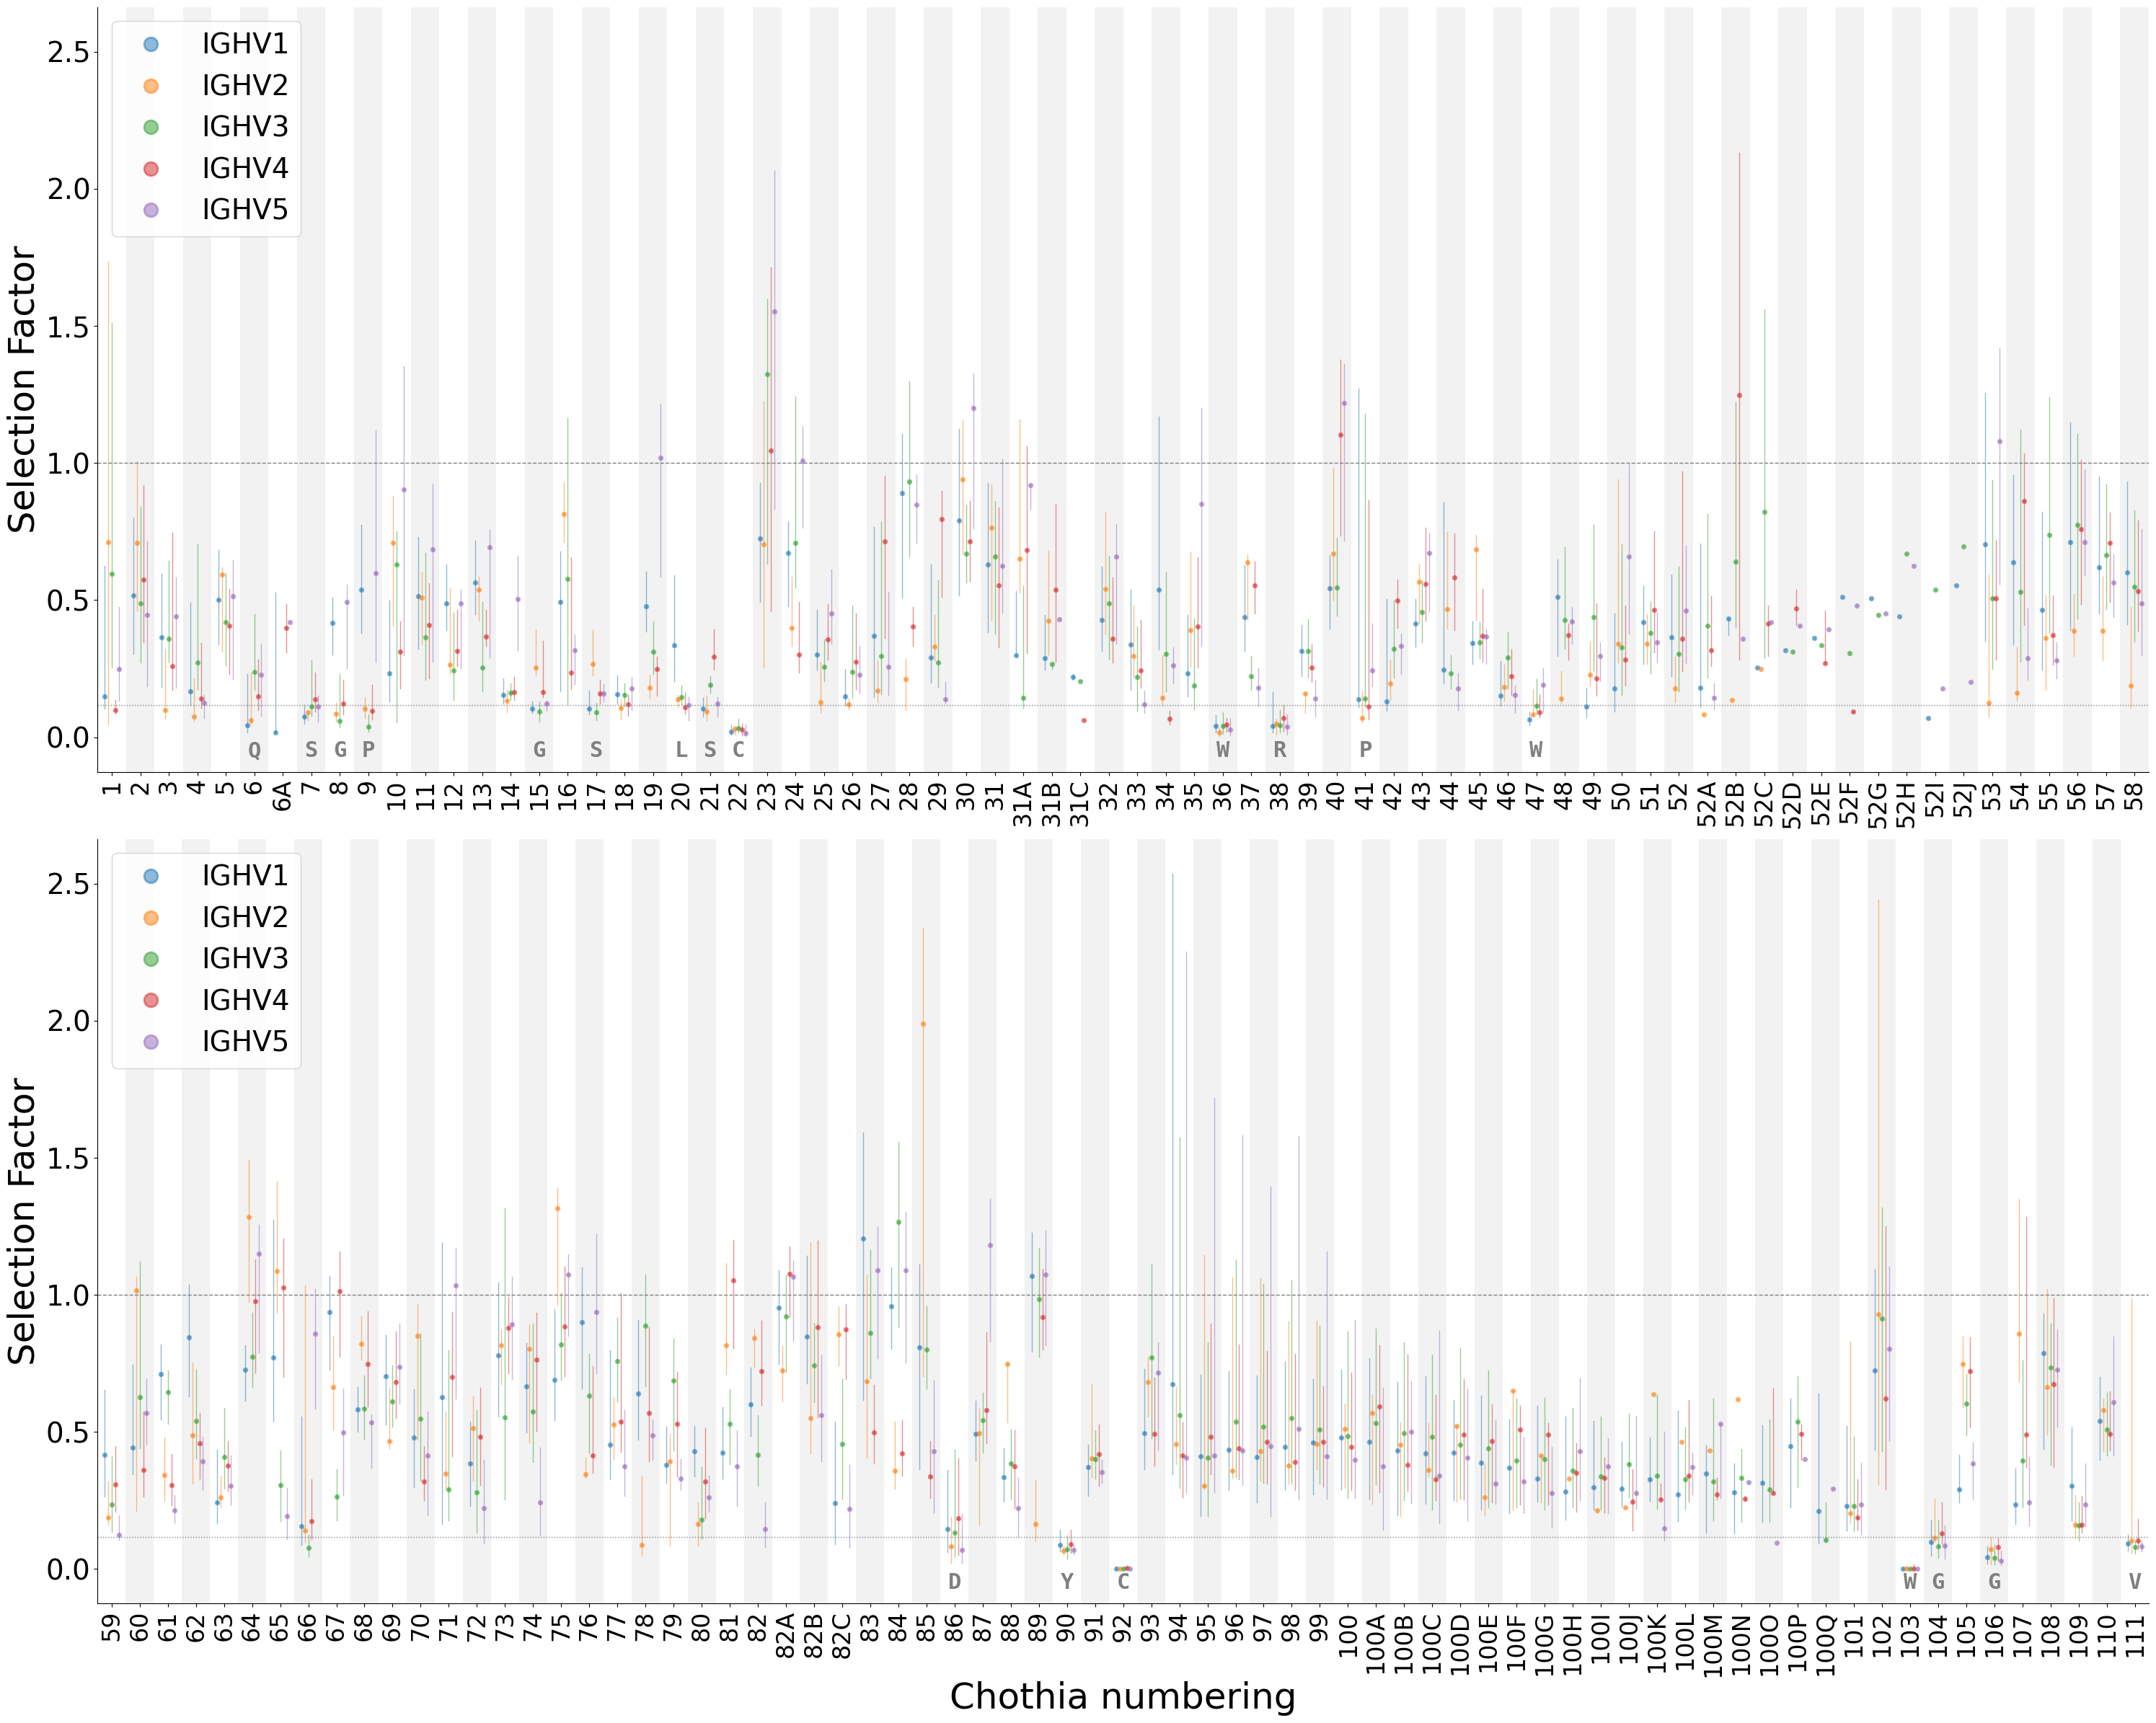

In [14]:

# make two subplots on top of one another
fig, axs = plt.subplots(2, 1, figsize=(30, 24), sharey=True)

plot_selection_factors(axs[0], popular_sites_df, conserved_aa_series, mode="first_half")
plot_selection_factors(axs[1], popular_sites_df, conserved_aa_series, mode="second_half")

fig.savefig(figures_dir + 'sabdab_selection_factors_2_row.svg', format='svg', bbox_inches='tight')

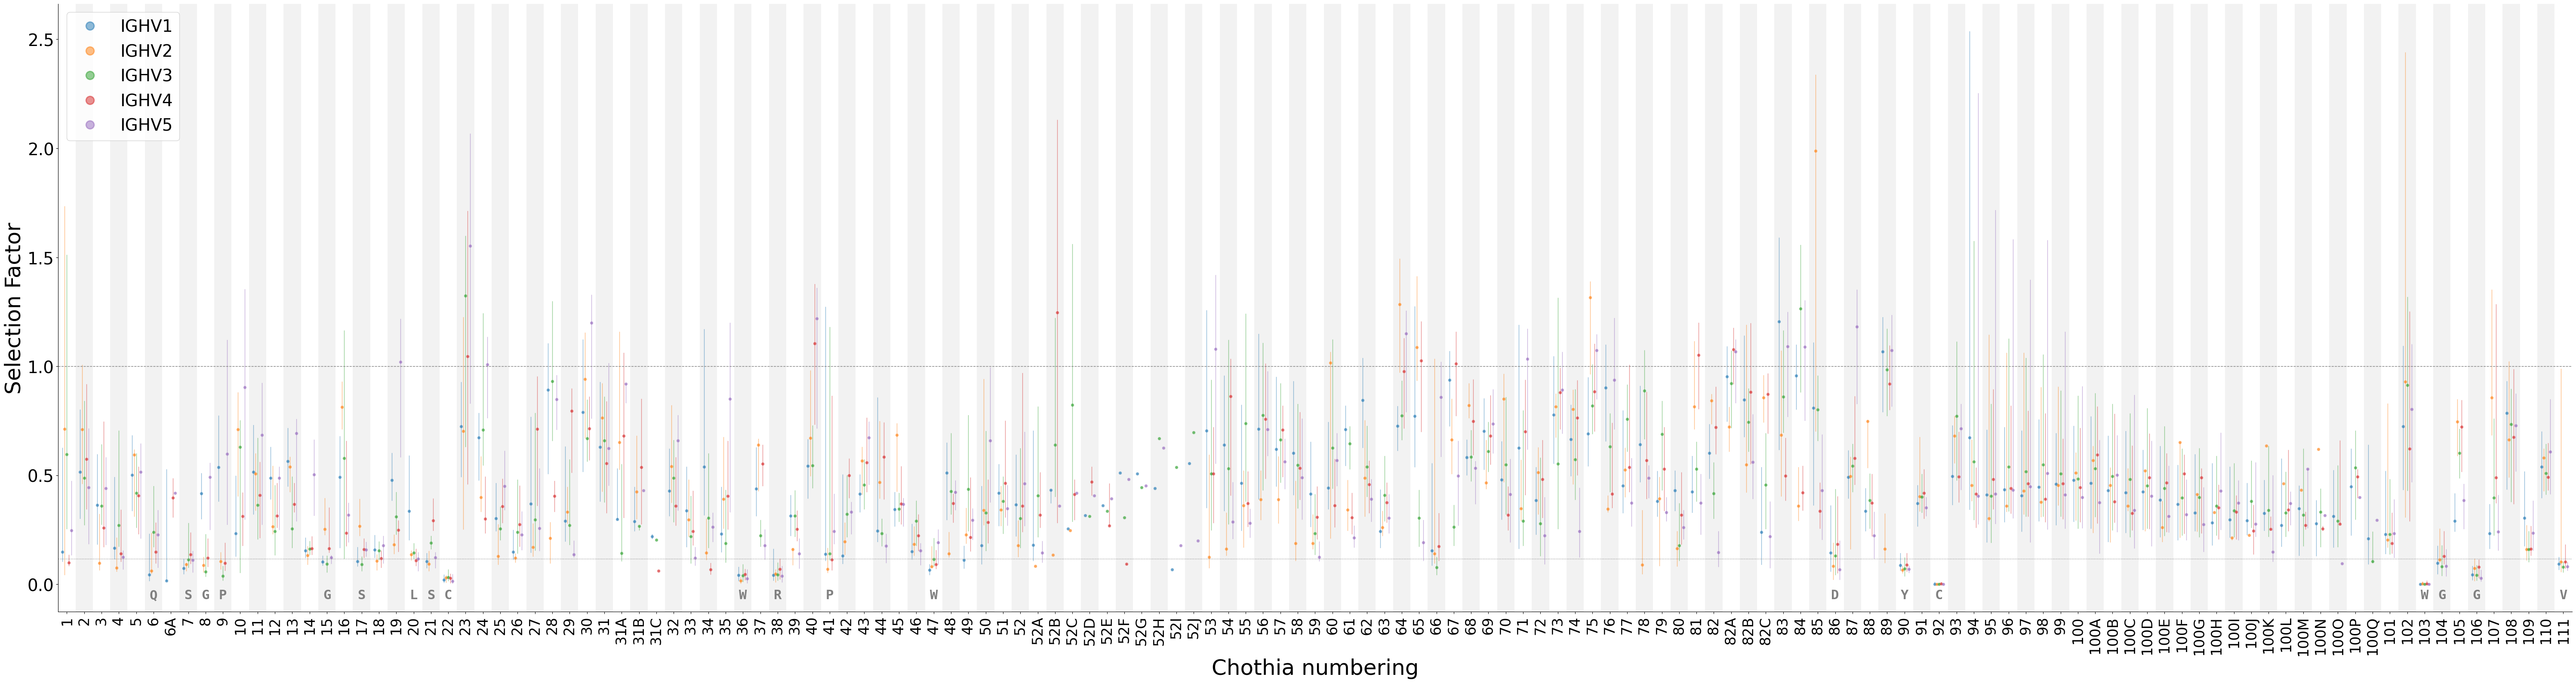

In [15]:
fig, ax = plt.subplots(figsize=(60, 16))
plot_selection_factors(ax, popular_sites_df, conserved_aa_series, mode="all")
fig.savefig(figures_dir + 'sabdab_selection_factors_overall.svg', format='svg', bbox_inches='tight')

### Would we see R R D Y if we just looked at the PDB amino acid frequencies in a naive way?

In [16]:
conserved_sites = conserved_aa_df.columns.tolist()
conserved_sites.sort(key=int)

popular_sites_list = list(popular_sites_df["site"].unique())

conserved_site_aa_df = chainseq_df[["pdbid", "abid", "vh_family"]+popular_sites_list]
conserved_site_aa_df.head(20).to_clipboard()

from collections import defaultdict
frequency_dict = defaultdict(list)

for site in popular_sites_list:
    vc = conserved_site_aa_df[site].value_counts()
    frequency_dict["site"].append(site)
    frequency_dict["aa"].append(vc.index[0])
    frequency_dict["frac"].append(vc.reset_index(drop=True)[0]/len(conserved_site_aa_df))

frequency_df = pd.DataFrame(frequency_dict)
frequency_df = frequency_df[frequency_df["aa"] != "-"]
frequency_df
conserved_frequency_df = frequency_df[frequency_df["site"].isin(conserved_sites)]
conserved_frequency_df

,site,aa,frac
5,6,E,0.628090
7,7,S,0.977408
8,8,G,0.992327
9,9,G,0.476130
15,15,G,0.838235
17,17,S,0.828645
20,20,L,0.622549
21,21,S,0.840580
22,22,C,0.999787
39,36,W,0.999787


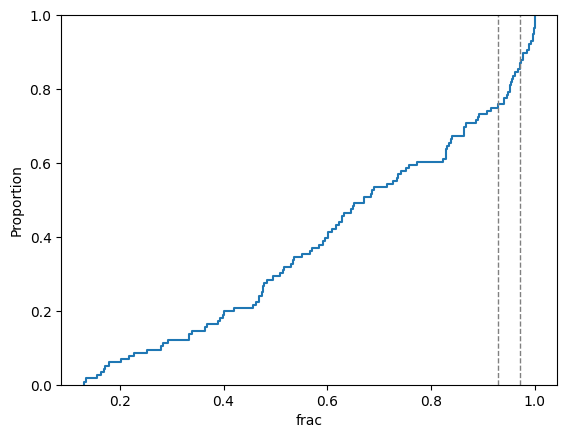

In [17]:
sns.ecdfplot(data=frequency_df, x='frac')
plt.axvline(x=0.9283891, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0.971867, color='gray', linestyle='--', linewidth=1)

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_79894/1288870853.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["frac"] = df["site"].apply(lambda x: frequency_df[frequency_df["site"] == x]["frac"].values[0]).copy()


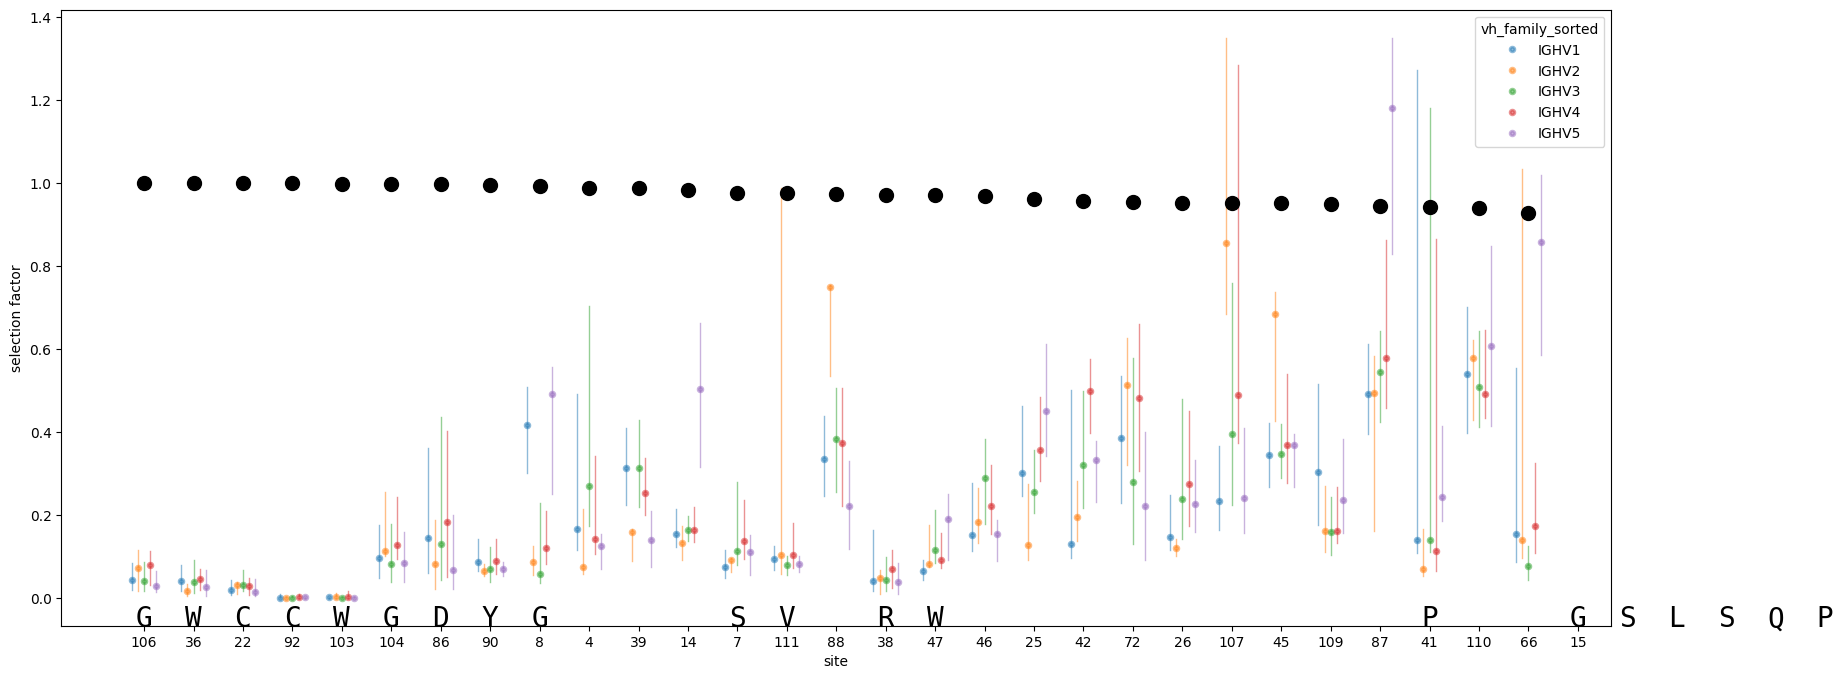

In [18]:
plt.figure(figsize=(20, 8))

palette = plt.get_cmap('tab10').colors

high_frequency_sites = frequency_df[frequency_df["frac"] > 0.92838]["site"].tolist()
high_frequency_sites
df = popular_sites_df[popular_sites_df["site"].isin(high_frequency_sites)]
df["frac"] = df["site"].apply(lambda x: frequency_df[frequency_df["site"] == x]["frac"].values[0]).copy()
# sort df by frac
df = df.sort_values(by="frac", ascending=False)

sns.pointplot(data=df, x="site", y="selection factor", hue="vh_family_sorted", linestyle='none', alpha=0.5, dodge=0.5,
              palette=palette, markers='.', errorbar=('pi', 75), estimator=np.median, err_kws={'linewidth': 1})

# make a dot plot of frequency_df["frac"] only for the high_frequency_sites
plt.plot(frequency_df[frequency_df["site"].isin(high_frequency_sites)]["site"], frequency_df[frequency_df["site"].isin(high_frequency_sites)]["frac"], 'o', color='black', markersize=10)

for site, aa in conserved_aa_series.items():
    plt.text(site, -0.05, aa, ha='center', va='center', fontsize=20, color='black', font='monospace')

### Let's find some antibodies to look at

In [19]:
# write a function that takes a row of sd_df and returns a dataframe with one colmn "chainseq_b" with the sequence from "chainseq_b" and one column "dnsm" with the dnsm values for that sequence
def make_dnsm_df(row):
    df = pd.DataFrame({"chainseq_b": list(row["chainseq_b"]), "dnsm": row["dnsm"]})
    for column in ["pdbid", "abid", "vh_family"]:
        df[column] = row[column]
    df["position"] = df.index + 1
    return df

# apply make_dnsm_df to every row of sd_df, and stack into a single dataframe
dnsm_df = pd.concat([make_dnsm_df(row) for _, row in sd_df.iterrows()])
# reset index of dnsm_df and set to be a "position" column
dnsm_df.reset_index(drop=True, inplace=True)
dnsm_df

,chainseq_b,dnsm,pdbid,abid,vh_family,position
0,E,0.633693,1adq,1adqHL,IGHV3,1
1,V,0.282328,1adq,1adqHL,IGHV3,2
2,Q,0.429063,1adq,1adqHL,IGHV3,3
3,L,0.169452,1adq,1adqHL,IGHV3,4
4,V,0.424491,1adq,1adqHL,IGHV3,5
...,...,...,...,...,...,...
566914,T,0.460757,7stf,7stfHL,IGHV3,113
566915,L,0.825187,7stf,7stfHL,IGHV3,114
566916,V,0.169617,7stf,7stfHL,IGHV3,115
566917,T,0.435905,7stf,7stfHL,IGHV3,116


In [20]:
sd_df["vh_family"].value_counts()

vh_family
IGHV3    2237
IGHV1    1502
IGHV4     604
IGHV5     163
IGHV2     104
IGHV7      51
IGHV6      31
Name: count, dtype: int64

In [21]:
# sort sd_df[sd_df["vb"] == "IGHV2-5*02"] by "resolution" and take the first 10
sd_df[sd_df["vb"] == "IGHV2-5*02"].sort_values("resolution").head(10)

,organism,pdbid,abid,resolution,method,pdbfile,va,ja,cdr3a,va_mismatches,...,jb,cdr3b,vb_mismatches,jb_mismatches,core_check_b,chainseq_b,chothia_a,chothia_b,vh_family,dnsm
3528,human_ig,7wti,7wtiHL,0,ELECTRON MICROSCOPY,/home/pbradley/csdat/sabdab/ig_only/7wtiHL_ig_...,IGLV2-23*04,IGLJ3*01,CCSYTTTTIPVAF,8,...,IGHJ4*01,CAHHKIEYIFDYW,10,1,True,ITLKESGPTLVKPTQTLTLTCAFSGFSLNTGGAGVGWIRQPPGKAL...,"3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21...","2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...",IGHV2,"[tensor(1.0292), tensor(0.3358), tensor(0.3330..."
3504,human_ig,7wrj,7wrjAB,0,ELECTRON MICROSCOPY,/home/pbradley/csdat/sabdab/ig_only/7wrjAB_ig_...,IGLV1-36*01,IGLJ3*01,CETWDDSLSGVVF,16,...,IGHJ3*02,CAHRPDLDSDLIVVDAFDMW,11,0,True,QITLKESGPTLVKPKQTLTLTCTFSGFSLKKNGVGVGWIRQPPGKA...,"4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,2...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(0.0751), tensor(0.5572), tensor(0.1122..."
3530,human_ig,7wti,7wtiGJ,0,ELECTRON MICROSCOPY,/home/pbradley/csdat/sabdab/ig_only/7wtiGJ_ig_...,IGLV2-23*04,IGLJ3*01,CCSYTTTTIPVAF,8,...,IGHJ4*01,CAHHKIEYIFDYW,10,1,True,ITLKESGPTLVKPTQTLTLTCAFSGFSLNTGGAGVGWIRQPPGKAL...,"3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21...","2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...",IGHV2,"[tensor(1.0292), tensor(0.3358), tensor(0.3330..."
3529,human_ig,7wti,7wtiIK,0,ELECTRON MICROSCOPY,/home/pbradley/csdat/sabdab/ig_only/7wtiIK_ig_...,IGLV2-23*04,IGLJ3*01,CCSYTTTTIPVAF,8,...,IGHJ4*01,CAHHKIEYIFDYW,10,1,True,ITLKESGPTLVKPTQTLTLTCAFSGFSLNTGGAGVGWIRQPPGKAL...,"3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21...","2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...",IGHV2,"[tensor(1.0292), tensor(0.3358), tensor(0.3330..."
3336,human_ig,7v27,7v27BA,0,ELECTRON MICROSCOPY,/home/pbradley/csdat/sabdab/ig_only/7v27BA_ig_...,IGLV2-23*04,IGLJ3*01,CSSYTTTSVVF,5,...,IGHJ5*01,CARLTAADTIFDCW,6,0,True,QVTLRESGPTLVKPKQTLTLTCTFSGFSLSTPGGGVGWIRQPPGKA...,"3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(0.0451), tensor(0.9578), tensor(0.0662..."
327,human_ig,4g6m,4g6mHL,1.81,X-RAY DIFFRACTION,/home/pbradley/csdat/sabdab/ig_only/4g6mHL_ig_...,IGKV1D-39*01,IGKJ1*01,CLQGKMLPWTF,12,...,IGHJ5*01,CARNRYDPPWFVDW,27,0,True,QVQLQESGPGLVKPSQTLSLTCSFSGFSLSTSGMGVGWIRQPSGKG...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(0.0872), tensor(0.7689), tensor(0.3202..."
194,human_ig,3idg,3idgBA,1.86,X-RAY DIFFRACTION,/home/pbradley/csdat/sabdab/ig_only/3idgBA_ig_...,IGKV1D-13*01,IGKJ4*01,CQQLHFYPHTF,11,...,IGHJ6*01,CAHRRGPTTLFGVPIARGPVNAMDVW,14,2,True,RITLKESGPPLVKPTQTLTLTCSFSGFSLSDFGVGVGWIRQPPGKA...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(1.7342), tensor(0.7097), tensor(0.0982..."
24,human_ig,1tjg,1tjgHL,2.0,X-RAY DIFFRACTION,/home/pbradley/csdat/sabdab/ig_only/1tjgHL_ig_...,IGKV1D-13*01,IGKJ4*01,CQQLHFYPHTF,11,...,IGHJ6*01,CAHRRGPTTLFGVPIARGPVNAMDVW,14,2,True,RITLKESGPPLVKPTQTLTLTCSFSGFSLSDFGVGVGWIRQPPGKA...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(1.7342), tensor(0.7097), tensor(0.0982..."
58,human_ig,2f5b,2f5bHL,2.0,X-RAY DIFFRACTION,/home/pbradley/csdat/sabdab/ig_only/2f5bHL_ig_...,IGKV1D-13*01,IGKJ4*01,CQQLHFYPHTF,11,...,IGHJ6*01,CAHRRGPTTLFGVPIARGPVNAMDVW,14,2,True,RITLKESGPPLVKPTQTLTLTCSFSGFSLSDFGVGVGWIRQPPGKA...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",IGHV2,"[tensor(1.7342), tensor(0.7097), tensor(0.0982..."
30,human_ig,1u8i,1u8iBA,2.0,X-RAY DIFFRACTION,/home/pbradley/csdat/sabdab/ig_only/1u8iBA_ig_...,IGKV1D-13*01,IGKJ4*01,CQQLHFYPHTF,11,...,IGHJ6*01,CAHRRGPTTLFGVPIARGPVNAMDVW,14,2,True,RITLKESGPPLVKPTQTLTLTCSFSGFSLSDFGVGVGWIRQPPGKA...,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,1

In [22]:
sd_df[sd_df["vb"].str.startswith("IGHV4-59")]["vb"].value_counts()

vb
IGHV4-59*01    81
IGHV4-59*11    33
IGHV4-59*04     8
IGHV4-59*05     3
IGHV4-59*02     3
IGHV4-59*07     1
Name: count, dtype: int64

Index(['RIGHV3', 'RIGHV1', 'TIGHV4', 'TIGHV1', 'KIGHV5', 'KIGHV3', 'DIGHV2',
       'KIGHV1', 'TIGHV3', 'SIGHV2', 'TIGHV6', 'KIGHV7', 'GIGHV3'],
      dtype='object', name='aa+family')


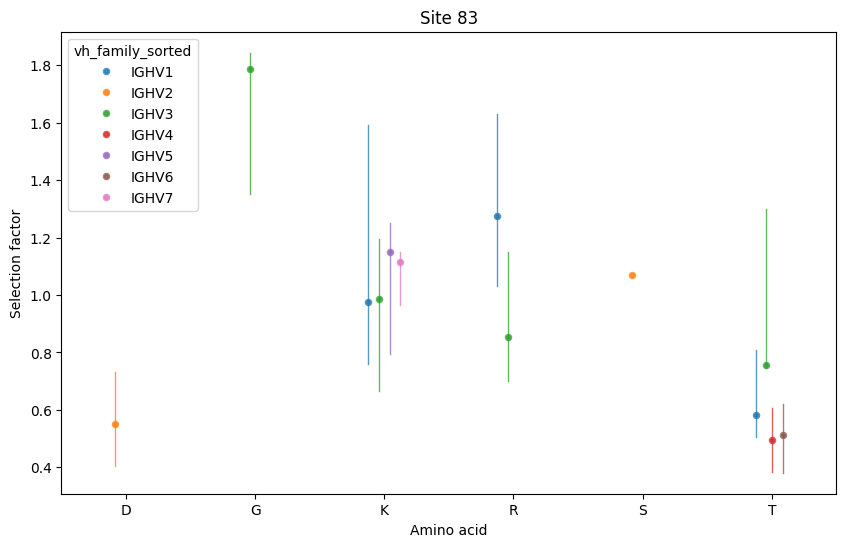

In [23]:
def sel_and_aas_at_chothia_site(site):
    aas = []
    dnsm_values = []
    for chothia_str, aa_str, dnsm in zip(sd_df["chothia_b"], sd_df["chainseq_b"], sd_df["dnsm"]):
        sites = chothia_str.split(",")
        if site in sites:
            idx = sites.index(site)
            aas.append(aa_str[idx])
            dnsm_values.append(dnsm[idx].item())
        else:
            aas.append(None)
            dnsm_values.append(np.nan)
    return pd.DataFrame({"aa": aas, "dnsm": dnsm_values, "vh_family": sd_df["vh_family"]})

def plot_aa_vs_sel_at_chothia_site(site, min_counts_per=25):
    df = sel_and_aas_at_chothia_site(site)
    df["vh_family_sorted"] = pd.Categorical(df["vh_family"], categories=np.sort(df["vh_family"].unique()), ordered=True)
    # make a df["aa+family"] column that is a concatenation of aa and vh_family
    df["aa+family"] = df["aa"] + df["vh_family"]
    # find families with at least min_counts_per_vh_family counts
    counts = df["aa+family"].value_counts()
    frequent = counts[counts >= min_counts_per].index
    print(frequent)
    df = df[df["aa+family"].isin(frequent)]
    df.sort_values("aa", inplace=True)
    plt.figure(figsize=(10, 6))
    sns.pointplot(data=df, x="aa", y="dnsm", hue="vh_family_sorted", dodge=0.25, linestyle="none", markers='.', errorbar=('pi', 75), estimator=np.median, err_kws={'linewidth': 1}, alpha=0.75)
    #sns.boxplot(data=df, x="aa", y="dnsm", hue="vh_family")
    plt.xlabel("Amino acid")
    plt.ylabel("Selection factor")
    plt.title(f"Site {site}")
    plt.show()

plot_aa_vs_sel_at_chothia_site("83")

Index(['QIGHV3', 'QIGHV1', 'QIGHV4', 'QIGHV5', 'QIGHV2', 'QIGHV7', 'QIGHV6'], dtype='object', name='aa+family')


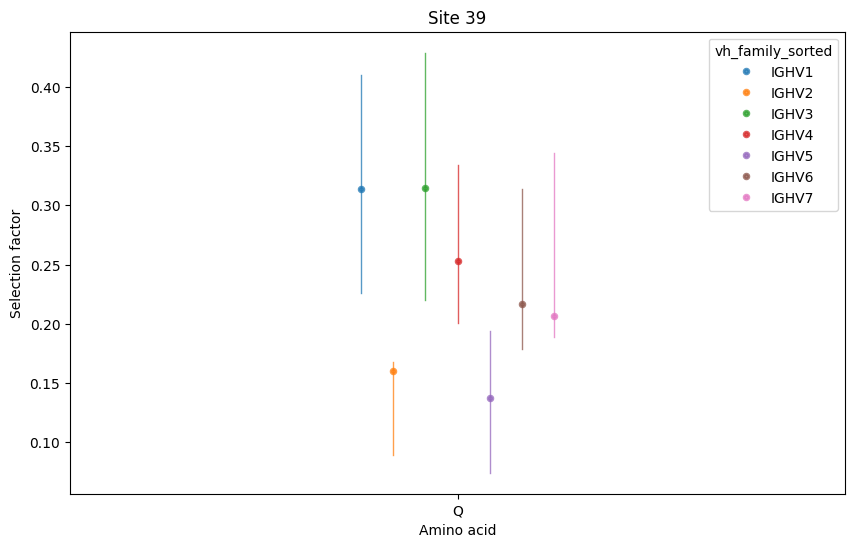

In [24]:

plot_aa_vs_sel_at_chothia_site("39")